Write a python program to implement the following motion estimation algorithms 1) Full search; 2) Three step search 3) Diamond search; 4) Diamond search with predicted initial positions; Test video sequences in YUV format (`akiyo_cif.yuv`) Perform motion estimation only with the Y component of the video frame. From each frame F(n) and its previous frame F(n−1), apply the above algorithms to find the best matches for all MBs, compute the average SAD, record the average number of SAD computations, and compare the performance (average SAD, average number of SAD computations) by plotting the following figures and table. 

In [509]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from tqdm.notebook import trange, tqdm

In [3]:
def read_YUV_file(file_path, frame_index, frame_height=288, frame_width=352):
    Y_size = frame_height * frame_width
    UV_size = Y_size // 2

    frame_size = Y_size + UV_size

    with open(file_path, 'rb') as f:
        f.seek(frame_size * frame_index)
        Y_data = np.frombuffer(f.read(Y_size), dtype=np.uint8).reshape(frame_height, frame_width)
        U_data = np.frombuffer(f.read(UV_size // 2), dtype=np.uint8).reshape(frame_height // 2, frame_width // 2)
        V_data = np.frombuffer(f.read(UV_size // 2), dtype=np.uint8).reshape(frame_height // 2, frame_width // 2)

    return Y_data

In [4]:
def SAD(block1, block2):
    return np.sum(np.abs(block1 - block2))

## Search Alogrithm

### Full Search

In [409]:
def full_search(block, search_area, block_start_row_relative, block_start_col_relative, dx_dy_list_from_prev_frame):
    min_sad = float('inf')
    dx, dy = 0, 0
    block_size = block.shape
    sad_call_count = 0
    best_match_sad = 0
    # print block and search area shape
    # print("block shape: ", block.shape)
    # print("search area shape: ", search_area.shape)

    for i in range(search_area.shape[0] - block_size[0] + 1): # row
        for j in range(search_area.shape[1] - block_size[1] + 1): # col
            search_block = search_area[i:i+block_size[0], j:j+block_size[1]]
            sad = SAD(block, search_block)
            sad_call_count = sad_call_count + 1
            
            if sad < min_sad:
                min_sad = sad
                dy, dx = i, j
                best_match_sad = sad_call_count
                best_residual = block - search_block
                
                
    # print("original dx, dy: ", dx, dy)
    # print("mse of residual", np.sum(best_residual**2) / (block_size[0] * block_size[1]))
    return dx, dy, min_sad, sad_call_count, best_match_sad, best_residual

### Three Step Search


In [410]:
def three_step_search(block, search_area, block_start_row_relative, block_start_col_relative, dx_dy_list_from_prev_frame):
    """
    Three Step Search block matching algorithm
    Args:
        block: the block we're trying to match
        search_area: the area of the image we're searching within

    Returns:
        The x and y displacements (dx, dy) of the best matching block within the search area
    """
    dx, dy = 0, 0
    sad_call_count = 0
    best_match_sad = 0

    # Initial step size
    step_size = 4
    while step_size >= 1:
        min_sad = np.inf

        # Slide the block over the search area, refers to teh left top corner of the block
        for i in [np.maximum(block_start_row_relative - step_size,0), block_start_row_relative, np.minimum(block_start_row_relative + step_size, search_area.shape[0] - block.shape[0])]:
            for j in [np.maximum(block_start_col_relative - step_size,0), block_start_col_relative, np.minimum(block_start_col_relative + step_size, search_area.shape[1] - block.shape[1])]:
                search_block = search_area[i:i+block.shape[0], j:j+block.shape[1]]
                # print search area shape
                # print("block shape:", block.shape)
                # print("search area shape: ", search_area.shape)
                # print("max x: ", np.minimum(block_start_col_relative + step_size, search_area.shape[1] - block.shape[1] -1))
                # print("j:", j)

                # Compute SAD
                sad = np.sum(np.abs(block - search_block))
                sad_call_count = sad_call_count + 1

                if sad < min_sad:
                    min_sad = sad
                    dx= j
                    dy = i
                    best_match_sad = sad_call_count
                    best_residual = block - search_block

        # update block_start_row_relative, block_start_col_relative
        block_start_row_relative = dy
        block_start_col_relative = dx

        # Decrease the step size
        step_size //= 2

    # The final best match is the displacement of the block
    return dx, dy, min_sad, sad_call_count, best_match_sad, best_residual


### Diamond Search

In [437]:
def diamond_search(
    block,
    search_area,
    block_start_row_relative,
    block_start_col_relative,
    dx_dy_list_from_prev_frame=None, # data order: [dx, dy]
):
    """
    Perform a diamond search to find the best matching block in the search area.

    Args:
        block: The block to be matched.
        search_area: The area in which to search for a match.

    Returns:
        dx, dy: The x and y displacements from the center of the search area to the best match.
    """
    SDSP = [(-1, 0), (0, -1), (0, 0), (0, 1), (1, 0)]  # Small diamond search pattern
    sad_call_count = 0
    best_match_sad = 0

    search_height, search_width = search_area.shape
    block_height, block_width = block.shape

    center_y, center_x = (
        np.clip(block_start_row_relative + dx_dy_list_from_prev_frame[1], 0, search_height - block_height),
        np.clip(block_start_col_relative + dx_dy_list_from_prev_frame[0], 0, search_width - block_width),
    )

    # Initialize the best match to the center of the search area
    min_sad = np.sum(
        np.abs(block- search_area[center_y : center_y + block_height, center_x : center_x + block_width])
    )
    best_match = (center_y, center_x)

    while True:
        current_sad = min_sad

        for dy, dx in SDSP:
            y, x = best_match[0] + dy, best_match[1] + dx

            if (
                y < 0
                or y + block_height > search_height
                or x < 0
                or x + block_width > search_width
            ):
                continue  # Skip if the block is out of bounds

            # Compute the SAD for the current position
            sad = np.sum(
                np.abs(block - search_area[y : y + block_height, x : x + block_width])
            )
            sad_call_count = sad_call_count + 1

            if sad < min_sad:
                min_sad = sad
                best_match = (y, x)

        # If the SAD did not decrease, we have found the best match
        if current_sad == min_sad:
            best_match_sad = sad_call_count
            best_residual = (
                block
                - search_area[
                    best_match[0] : best_match[0] + block_height,
                    best_match[1] : best_match[1] + block_width,
                ]
            )
            break

    # Compute the displacements from the center of the search area to the best match
    dy = best_match[0] - block_start_row_relative
    dx = best_match[1] - block_start_col_relative

    return dx, dy, min_sad, sad_call_count, best_match_sad, best_residual


In [438]:
def block_search(
    frame1,
    frame2,
    block_size,
    search_area_size,
    block_start_row,
    block_start_col,
    search_alogorithm,
    dx_dy_list_from_prev_frame=np.array([0, 0]),
):

    # Select a block from the first frame
    block = frame1[
        block_start_row : block_start_row + block_size,
        block_start_col : block_start_col + block_size,
    ]

    # Select a search area from the second frame
    search_area_start_row = np.maximum(
        block_start_row - (search_area_size - block_size) // 2, 0
    )
    search_area_start_col = np.maximum(
        block_start_col - (search_area_size - block_size) // 2, 0
    )
    search_area_end_row = np.min(
        [search_area_start_row + search_area_size, frame1.shape[0]]
    )
    search_area_end_col = np.min(
        [search_area_start_col + search_area_size, frame1.shape[1]]
    )

    # print the search area location
    # print(f"Search area: ({search_area_start_row}, {search_area_start_col}) - ({search_area_end_row}, {search_area_end_col})")
    search_area = frame2[
        search_area_start_row:search_area_end_row,
        search_area_start_col:search_area_end_col,
    ]

    # calculate the relative position of the block in the search area
    block_start_row_relative = block_start_row - search_area_start_row
    block_start_col_relative = block_start_col - search_area_start_col

    # Apply full search algorithm
    block_start_col_relative = block_start_col - search_area_start_col
    dx, dy, min_sad, sad_call_count, best_match_sad, best_residual = search_alogorithm(
        block,
        search_area,
        block_start_row_relative,
        block_start_col_relative,
        dx_dy_list_from_prev_frame,
    )

    dy = dy + search_area_start_row - block_start_row
    dx = dx + search_area_start_col - block_start_col

    # Print the result
    # print(f"Displacement: ({dx}, {dy}), Minimum SAD: {min_sad}")

    return dx, dy, min_sad, sad_call_count, best_match_sad, best_residual


In [439]:
def split_and_search(
    frame1,
    frame2,
    block_size,
    search_area_size,
    search_alogorithm,
    dx_dy_list_from_prev_frame=None,
):
    sad_call_count = 0
    dx_dy_list = np.zeros(
        [2, frame1.shape[0] // block_size, frame1.shape[1] // block_size], dtype=int
    )
    if dx_dy_list_from_prev_frame is None:
        dx_dy_list_from_prev_frame = np.zeros(
            [2, frame1.shape[0] // block_size, frame1.shape[1] // block_size], dtype=int
        )
    min_sad_list = []
    frame1_mv = frame1.copy()
    # frame1_mv = np.zeros(frame1.shape)
    frame1_prediction_residual = np.zeros(frame1.shape)
    for block_start_row in range(0, frame1.shape[0], block_size):
        for block_start_col in range(0, frame1.shape[1], block_size):
            (
                dx,
                dy,
                min_sad,
                sad_call_count,
                best_match_sad,
                best_residual,
            ) = block_search(
                frame1,
                frame2,
                block_size,
                search_area_size,
                block_start_row,
                block_start_col,
                search_alogorithm,
                dx_dy_list_from_prev_frame[
                    :, block_start_row // block_size, block_start_col // block_size
                ], # data order is dx, dy
            )
            dx_dy_list[
                0, block_start_row // block_size, block_start_col // block_size
            ] = dx
            dx_dy_list[
                1, block_start_row // block_size, block_start_col // block_size
            ] = dy
            min_sad_list.append(min_sad)
            # print the position of current block
            # print(f"Block: ({block_start_row}, {block_start_col}) - ({block_start_row+block_size}, {block_start_col+block_size})")
            # print(f"dx: {dx}, dy: {dy}, apply area: ({block_start_row+dy}, {block_start_col+dx}) - ({block_start_row+block_size+dy}, {block_start_col+block_size+dx})")
            # print(frame1_mv[block_start_row+dy:block_start_row+block_size+dy, block_start_col+dx:block_start_col+block_size+dx].shape)
            # print(frame1[block_start_row:block_start_row+block_size, block_start_col:block_start_col+block_size].shape)
            frame1_mv[
                block_start_row + dy : block_start_row + block_size + dy,
                block_start_col + dx : block_start_col + block_size + dx,
            ] = frame1[
                block_start_row : block_start_row + block_size,
                block_start_col : block_start_col + block_size,
            ]
            frame1_prediction_residual[
                block_start_row : block_start_row + block_size,
                block_start_col : block_start_col + block_size,
            ] = best_residual
    # calculate the avg SAD
    avg_sad = np.mean(min_sad_list)
    # calculate average number of SAD computations
    avg_sad_call_count = best_match_sad
    # print avg dx and dy
    # print("avg dx: ", np.mean(dx_list))
    # print("avg dy: ", np.mean(dy_list))
    return (
        frame1_mv,
        frame1_prediction_residual,
        avg_sad,
        avg_sad_call_count,
        dx_dy_list,
    )


## Plot the performance of each algorithm

In [ ]:
# plot frame_mv, Y1, Y2 and residual
def plot_frame_mv(frame_mv, Y1, Y2):
    fig, axes = plt.subplots(2, 2, figsize=(10, 10))
    axes[0, 0].imshow(Y1, cmap='gray')
    axes[0, 0].set_title('Frame 1')
    axes[0, 1].imshow(Y2, cmap='gray')
    axes[0, 1].set_title('Frame 2')
    axes[1, 0].imshow(frame_mv, cmap='gray')
    axes[1, 0].set_title('Frame 1 with motion vectors')
    axes[1, 1].imshow(frame_prediction_residual, cmap='gray')
    axes[1, 1].set_title('Prediction residual')
    plt.show()

In [ ]:
def mse(frame1, frame2):
    return np.mean((frame1 - frame2) ** 2)

In [537]:
Y1= read_YUV_file('akiyo_cif.yuv', frame_index=2)
Y2= read_YUV_file('akiyo_cif.yuv', frame_index=3)
frame_mv, frame_prediction_residual, svg_sad, avg_sad_call_count, dx_dy_list = split_and_search(Y1,Y2,16,30, full_search)
print(mse(Y2, frame_mv))

10.93755918560606


In [538]:
Y1= read_YUV_file('akiyo_cif.yuv', frame_index=2)
Y2= read_YUV_file('akiyo_cif.yuv', frame_index=3)
frame_mv, frame_prediction_residual, svg_sad, avg_sad_call_count, dx_dy_list = split_and_search(Y1,Y2,16,30, three_step_search)
print(mse(Y2, frame_mv))

8.700244633838384


In [539]:
Y1= read_YUV_file('akiyo_cif.yuv', frame_index=2)
Y2= read_YUV_file('akiyo_cif.yuv', frame_index=3)
frame_mv, frame_prediction_residual, svg_sad, avg_sad_call_count, dx_dy_list = split_and_search(Y1,Y2,16,30, diamond_search)
print(mse(Y2, frame_mv))

51.884568339646464


In [540]:
Y1= read_YUV_file('akiyo_cif.yuv', frame_index=1)
Y2= read_YUV_file('akiyo_cif.yuv', frame_index=2)
Y3 = read_YUV_file('akiyo_cif.yuv', frame_index=3)
frame_mv, frame_prediction_residual, svg_sad, avg_sad_call_count, dx_dy_list = split_and_search(Y1,Y2,16,30, diamond_search)
frame_mv2, frame_prediction_residual2, svg_sad2, avg_sad_call_count2, dx_dy_list2 = split_and_search(Y2,Y3,16,30, diamond_search, dx_dy_list)
print(mse(Y3, frame_mv2))

53.22430358270202


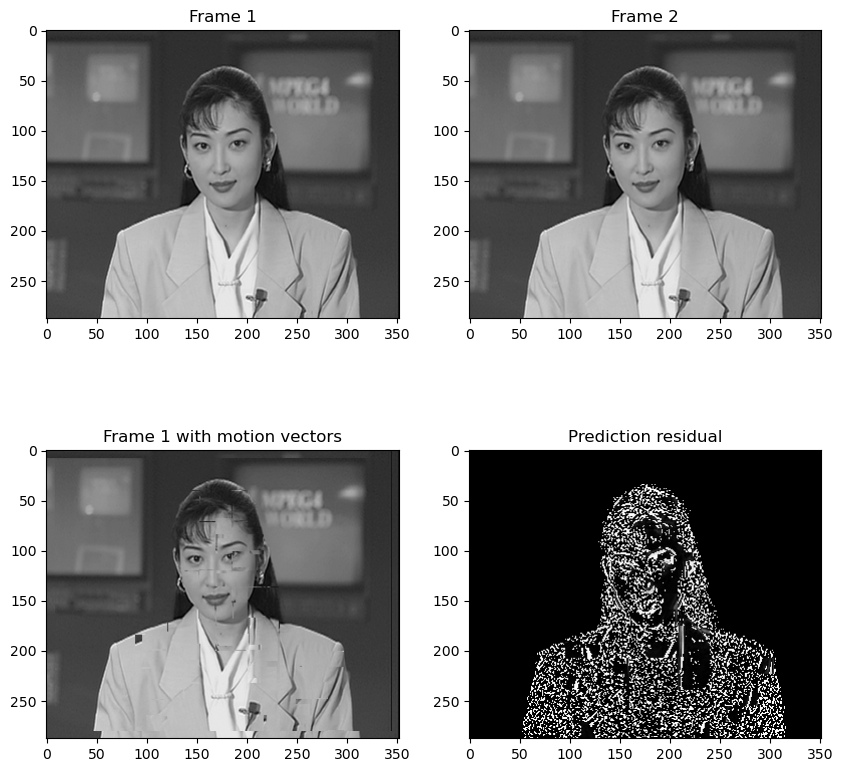

In [541]:
plot_frame_mv(frame_mv, Y1, Y2)

## Calculate the MSE per pixel, search point number for each method

In [511]:
# use the first 100 frames
mse_list = np.zeros([100,4])
sad_call_count_list = np.zeros([100,4])
motion_vector_from_prev_frame = np.zeros([101,2,288//16,352//16],dtype=int) # index0 is the motion vector of frame 1, index1 is the motion vector of frame 2, etc.

In [518]:
for i in trange(100):
    # print(f"Frame {i} and {i+1}")
    Y1 = read_YUV_file('bus_cif.yuv', frame_index=i)
    Y2 = read_YUV_file('bus_cif.yuv', frame_index=i+1)
    # full search
    frame_pred_2, frame_prediction_residual, avg_sad, avg_sad_call_count, dx_dy_list_from_prev_frame = split_and_search(Y1,Y2,16,30,full_search)
    mse_list[i,0] = mse_metric
    sad_call_count_list[i,0] = avg_sad_call_count
    # 3 step search
    frame_pred_2, frame_prediction_residual, avg_sad, avg_sad_call_count, dx_dy_list_from_prev_frame = split_and_search(Y1,Y2,16,30,three_step_search)
    mse_list[i,1] = mse_metric
    sad_call_count_list[i,1] = avg_sad_call_count
    # diamond search
    frame_pred_2, frame_prediction_residual, avg_sad, avg_sad_call_count, dx_dy_list_from_prev_frame = split_and_search(Y1,Y2,16,30,diamond_search)
    mse_list[i,2] = mse_metric
    sad_call_count_list[i,2] = avg_sad_call_count
    # diamond search with previous frame's motion vector
    frame_pred_2, frame_prediction_residual, avg_sad, avg_sad_call_count, dx_dy_list_from_prev_frame = split_and_search(Y1,Y2,16,30,diamond_search, motion_vector_from_prev_frame[i,:,:,:])
    motion_vector_from_prev_frame[i+1,:,:,:] = dx_dy_list_from_prev_frame
    mse_metric = np.average((Y2-frame_pred_2) ** 2)
    mse_list[i,3] = mse_metric
    sad_call_count_list[i,3] = avg_sad_call_count

  0%|          | 0/100 [00:00<?, ?it/s]

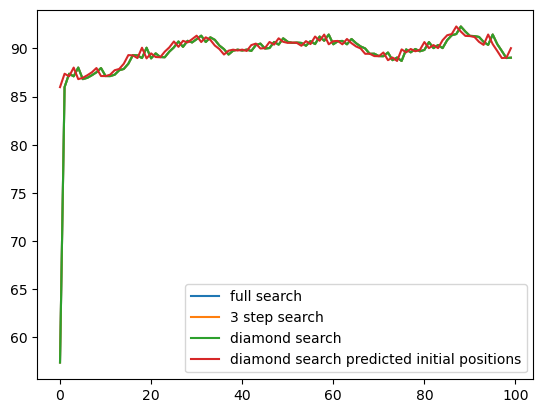

In [519]:
# plot the mse per pixel
plt.plot(mse_list[:,0],label='full search')
plt.plot(mse_list[:,1],label='3 step search')
plt.plot(mse_list[:,2],label='diamond search')
plt.plot(mse_list[:,3],label='diamond search predicted initial positions')
plt.legend()

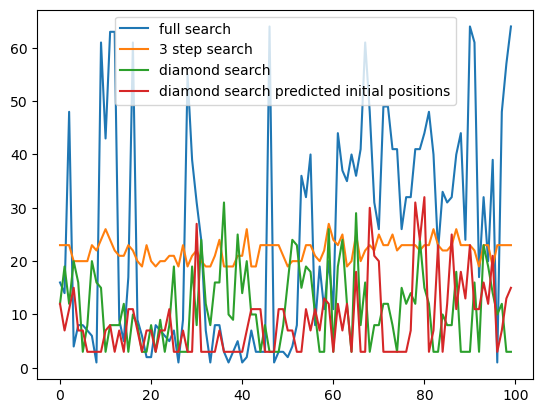

In [520]:
# plot sad_call_count_list
plt.plot(sad_call_count_list[:,0],label='full search')
plt.plot(sad_call_count_list[:,1],label='3 step search')
plt.plot(sad_call_count_list[:,2],label='diamond search')
plt.plot(sad_call_count_list[:,3],label='diamond search predicted initial positions')
plt.legend()